In [1]:
!pip install -q nnunetv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.3/206.3 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
import os
import shutil
import json
from glob import glob
import numpy as np
import cv2
from tqdm import tqdm

In [4]:
H, W = 512, 512
TASK_ID   = 1
TASK_NAME = "RetinalVessels"

NNUNET_RAW          = "/content/nnUNet_data"
NNUNET_PREPROCESSED = "/content/nnUNet_preprocessed"
NNUNET_RESULTS      = "/content/nnUNet_results"

In [5]:
dataset_folder = f"Dataset{TASK_ID:03d}_{TASK_NAME}"
base_dir = os.path.join(NNUNET_RAW, dataset_folder)

if os.path.isdir(base_dir):
    shutil.rmtree(base_dir)

for sub in ("imagesTr", "labelsTr", "imagesTs", "labelsTs"):
    os.makedirs(os.path.join(base_dir, sub), exist_ok=True)

In [16]:
import importlib
import data
importlib.reload(data)
from data import load_data, create_dir, augment_data

# drive_path = "/content/drive/MyDrive/Datasets/DRIVE"
drive_path = "/content/drive/MyDrive/Datasets/DRIVE_Shared/DRIVE"
(train_x, train_y), (test_x, test_y) = load_data(drive_path)
print("Train:", len(train_x), "images →", len(train_y), "masks")
print("Test: ", len(test_x),  "images →", len(test_y), "masks")

Train: 20 images → 20 masks
Test:  20 images → 20 masks


In [17]:
create_dir("new_data/train/image")
create_dir("new_data/train/mask")
create_dir("new_data/test/image")
create_dir("new_data/test/mask")

In [18]:
augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x,  test_y,  "new_data/test/",  augment=False)

100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


In [19]:
def binarize(mask_dir):
    for p in glob(os.path.join(mask_dir, "*.png")):
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        _, b = cv2.threshold(m, 127, 1, cv2.THRESH_BINARY)
        cv2.imwrite(p, b)

In [20]:
binarize("new_data/train/mask")
binarize("new_data/test/mask")

In [21]:
def convert_to_single_channel(img_dir):
    for p in glob(os.path.join(img_dir, "*.png")):
        img = cv2.imread(p)
        single = img[:, :, 1]
        cv2.imwrite(p, single)

In [22]:
convert_to_single_channel("new_data/train/image")
convert_to_single_channel("new_data/test/image")

In [23]:
train_imgs = sorted(glob("new_data/train/image/*.png"))
train_msks = sorted(glob("new_data/train/mask/*.png"))
assert len(train_imgs) == len(train_msks), "Mismatch between images and masks"
for i, (img, msk) in enumerate(zip(train_imgs, train_msks)):
    shutil.copy(img, os.path.join(base_dir, "imagesTr", f"case_{i:04d}_0000.png"))
    shutil.copy(msk, os.path.join(base_dir, "labelsTr", f"case_{i:04d}.png"))
print("Copied", len(train_imgs), "train cases")

Copied 120 train cases


In [24]:
test_imgs = sorted(glob("new_data/test/image/*.png"))
test_msks = sorted(glob("new_data/test/mask/*.png"))
assert len(test_imgs) == len(test_msks), "Mismatch between test images and masks"
for i, (img, msk) in enumerate(zip(test_imgs, test_msks)):
    shutil.copy(img, os.path.join(base_dir, "imagesTs", f"case_{i:04d}_0000.png"))
    shutil.copy(msk, os.path.join(base_dir, "labelsTs", f"case_{i:04d}.png"))
print("Copied", len(test_imgs), "test cases")

Copied 20 test cases


In [25]:
num_train = len(train_imgs)
dataset_json = {
    "channel_names": {"0": "green"},
    "labels":        {"background": 0, "vessel": 1},
    "file_ending":   ".png",
    "numTraining":   num_train
}
with open(os.path.join(base_dir, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

In [26]:
os.environ["nnUNet_raw"]          = NNUNET_RAW
os.environ["nnUNet_preprocessed"] = NNUNET_PREPROCESSED
os.environ["nnUNet_results"]      = NNUNET_RESULTS

In [27]:
!nnUNetv2_plan_and_preprocess -d {TASK_ID} --verify_dataset_integrity

Fingerprint extraction...
Dataset001_RetinalVessels
Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer
100% 120/120 [00:05<00:00, 23.88it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 6, 'patch_size': (np.int64(512), np.int64(512)), 'median_image_size_in_voxels': array([512., 512.]), 'spacing': array([1., 1.]), 'normalization_s

In [28]:
#good luck

In [29]:
!nnUNetv2_train {TASK_ID} 2d all


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-05-29 17:53:18.682555: Using torch.compile...
2025-05-29 17:53:20.665703: do_dummy_2d_data_aug: False
using pin_memory on device 0
using pin_memory on device 0

This is the configuration used by this training:
Configuration name: 2d
 {'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name'

In [30]:
# !zip -r /content/without_prediction_nnUNet_all_data.zip /content/* \
#     -x "/content/drive/*" \
#     -x "/content/sample_data/*"



	zip warning: name not matched: /content/drive/MyDrive/BBA Bus Report Writing Section 7 Friday 9.00 am/Mon Ploy Proud/Problem Solution Report (Byron Bay).gdoc
Scanning files 
	zip warning: name not matched: /content/drive/MyDrive/Unit 4.pdf
	zip warning: name not matched: /content/drive/MyDrive/Class Tasks
	zip warning: name not matched: /content/drive/MyDrive/Session 9
.

zip error: Interrupted (aborting)


In [31]:
!pwd

/content


In [32]:
!cd /content && zip -r without_prediction_nnUNet_all_data.zip . -x "drive/*" "sample_data/*"

	zip warning: name not matched: drive/MyDrive/BBA Bus Report Writing Section 7 Friday 9.00 am/Mon Ploy Proud/Problem Solution Report (Byron Bay).gdoc
	zip warning: name not matched: drive/MyDrive/Unit 4.pdf
	zip warning: name not matched: drive/MyDrive/Class Tasks
	zip warning: name not matched: drive/MyDrive/Session 9
Scanning files .............
	zip warning: name not matched: drive/.shortcut-targets-by-id/1uMcSIr8i4fM6NDaqqzMfwbYsIgR84Q3k/BBA Bus Report Writing Section 7 Friday 9.00 am/Mon Ploy Proud/Problem Solution Report (Byron Bay).gdoc
	zip warning: name not matched: drive/.Encrypted/.shortcut-targets-by-id/1--8RjFajpsFkV3QCJe214LAaHHX_W3iX/ราตรีสีฟ้าเภตราฯ
	zip warning: name not matched: drive/.Encrypted/.shortcut-targets-by-id/1uMcSIr8i4fM6NDaqqzMfwbYsIgR84Q3k/BBA Bus Report Writing Section 7 Friday 9.00 am
	zip warning: name not matched: drive/.Encrypted/.shortcut-targets-by-id/19VM2yJgTXXqNBArpEq0o04VDVoOhqU0B/Ais Term Project 
  adding: .config/ (stored 0%)
  adding: .conf

In [33]:
from google.colab import files
files.download("/content/without_prediction_nnUNet_all_data.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
!nnUNetv2_predict \
  -i /content/nnUNet_data/Dataset001_RetinalVessels/imagesTs \
  -o /content/nnUNet_predictions \
  -d 1 \
  -c 2d \
  -f all \
  -chk checkpoint_best.pth \
  --save_probabilities


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 20 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 20 cases that I would like to predict

Predicting case_0000:
perform_everything_on_device: True
100% 1/1 [00:02<00:00,  2.19s/it]
sending off prediction to background worker for resampling and export
done with case_0000

Predicting case_0001:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 25.14it/s]
sending off prediction to background worker for resampling and export
done with case_0001

Predicting case_0002:
perform_everything_on_device: True
100% 1/1 [00:0

In [ ]:
# !nnUNetv2_train {TASK_ID} 2d all -tr nnUNetTrainer_5epochs

In [ ]:
# !nnUNetv2_predict \
#   -i /content/nnUNet_data/Dataset001_RetinalVessels/imagesTs \
#   -o /content/nnUNet_predictions \
#   -d 1 \
#   -c 2d \
#   -tr nnUNetTrainer_5epochs \
#   -p nnUNetPlans \
#   -f all \
#   -chk checkpoint_best.pth \
#   --save_probabilities


In [35]:
base_dir    = "/content/nnUNet_data/Dataset001_RetinalVessels"
output_dir  = "/content/nnUNet_predictions"
ts_folder   = os.path.join(base_dir, "imagesTs")
labels_folder = os.path.join(base_dir, "labelsTs")
test_imgs   = sorted([f for f in os.listdir(ts_folder) if f.endswith("_0000.png")])
num_cases   = len(test_imgs)

In [36]:
def load_mask(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(f"Mask file not found: {path}")
    return (m.flatten() > 0).astype(np.float32)

def compute_iou_dice(gt, pr):
    inter = np.sum(gt * pr)
    union = np.sum(gt) + np.sum(pr) - inter
    iou  = inter / union if union > 0 else 0
    dice = 2 * inter / (np.sum(gt) + np.sum(pr)) if (np.sum(gt) + np.sum(pr)) > 0 else 0
    return iou, dice

In [37]:
results = []
for i in range(num_cases):
    idx = test_imgs[i].split("_")[1]
    gt = load_mask(os.path.join(labels_folder, f"case_{idx}.png"))
    pr = load_mask(os.path.join(output_dir,   f"case_{idx}.png"))
    results.append(compute_iou_dice(gt, pr))

mean_iou  = np.mean([r[0] for r in results])
mean_dice = np.mean([r[1] for r in results])
print(f"Mean IoU:  {mean_iou:.5f}")
print(f"Mean Dice: {mean_dice:.5f}")

Mean IoU:  0.68756
Mean Dice: 0.81468


In [38]:
from sklearn.metrics import roc_auc_score, log_loss
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
rows = []
for fname in tqdm(test_imgs, desc="Computing metrics"):
    idx = fname.split("_")[1]
    gt_png   = cv2.imread(os.path.join(labels_folder, f"case_{idx}.png"), cv2.IMREAD_GRAYSCALE).flatten()
    pr_png   = cv2.imread(os.path.join(output_dir,       f"case_{idx}.png"), cv2.IMREAD_GRAYSCALE).flatten()
    gt_bin   = (gt_png > 0).astype(int)
    pr_bin   = (pr_png > 0).astype(int)

    prob_npz = np.load(os.path.join(output_dir, f"case_{idx}.npz"))
    soft     = prob_npz['probabilities']  # shape (2, H, W)
    pr_prob  = np.clip(soft[1].flatten(), 1e-7, 1 - 1e-7)

    TP = np.logical_and(pr_bin==1, gt_bin==1).sum()
    FP = np.logical_and(pr_bin==1, gt_bin==0).sum()
    FN = np.logical_and(pr_bin==0, gt_bin==1).sum()
    TN = np.logical_and(pr_bin==0, gt_bin==0).sum()

    accuracy  = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP) if TP+FP else 0
    recall    = TP / (TP+FN) if TP+FN else 0
    iou       = TP / (TP+FP+FN) if TP+FP+FN else 0
    dice_coef = 2*TP / (2*TP+FP+FN) if (2*TP+FP+FN) else 0
    try:
        auc_val  = roc_auc_score(gt_bin, pr_prob)
        loss_val = log_loss(gt_bin, pr_prob)
    except ValueError:
        auc_val, loss_val = np.nan, np.nan

    rows.append({
        "case":       int(idx),
        "accuracy":   accuracy,
        "precision":  precision,
        "recall":     recall,
        "iou":        iou,
        "dice_coef":  dice_coef,
        "auc":        auc_val,
        "loss":       loss_val
    })

df = pd.DataFrame(rows).sort_values("case").reset_index(drop=True)
mean_vals = df.drop(columns="case").mean()
df.loc[len(df)] = ["mean", *mean_vals.values]

csv_path = "metrics.csv"
df.to_csv(csv_path, index=False)

print(f"Saved full metrics to {csv_path}")

Computing metrics: 100%|██████████| 20/20 [00:01<00:00, 11.02it/s]


Saved full metrics to metrics.csv


In [40]:
df

,case,accuracy,precision,recall,iou,dice_coef,auc,loss
0,0,0.968590,0.806117,0.851497,0.706756,0.828186,0.988097,0.171007
1,1,0.968666,0.881661,0.801669,0.723788,0.839764,0.986050,0.179527
2,2,0.962830,0.858579,0.748731,0.666530,0.799901,0.981992,0.184060
3,3,0.968910,0.907093,0.734718,0.683298,0.811857,0.974545,0.183627
4,4,0.966442,0.881876,0.740322,0.673532,0.804923,0.971025,0.216520
5,5,0.964100,0.897250,0.711178,0.657620,0.793451,0.971535,0.222359
6,6,0.967640,0.881210,0.747753,0.679282,0.809015,0.974683,0.199677
7,7,0.967731,0.853766,0.753606,0.667453,0.800566,0.974421,0.192800
8,8,0.970707,0.843150,0.782703,0.683223,0.811803,0.980599,0.157033
9,9,0.970024,0.827791,0.799505,0.685491,0.813402,0.979779,0.168757


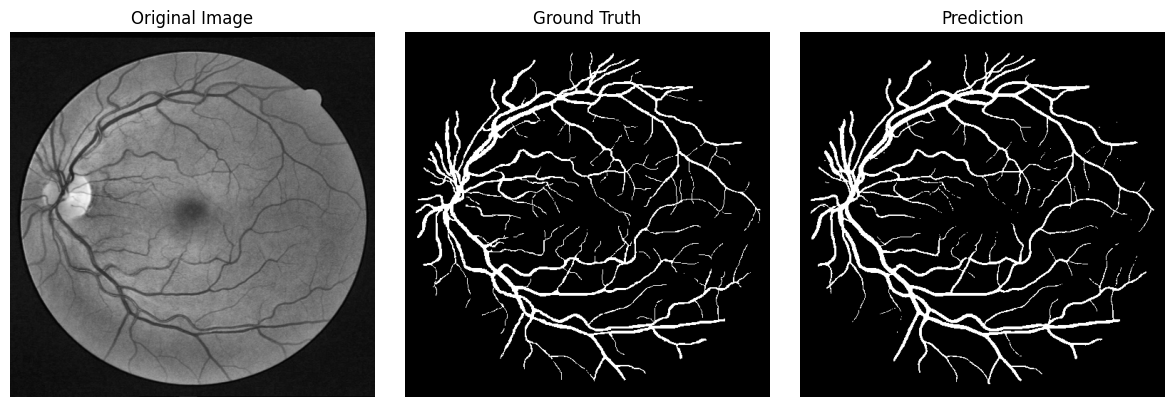

In [41]:
N = 1
selected = test_imgs[:N]
fig, axes = plt.subplots(N, 3, figsize=(12, 4 * N))
if N == 1:
    axes = axes[np.newaxis, :]

for row, fname in enumerate(selected):
    idx = fname.split("_")[1]
    orig = cv2.imread(os.path.join(ts_folder, fname), cv2.IMREAD_COLOR)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    gt   = cv2.imread(os.path.join(labels_folder, f"case_{idx}.png"), cv2.IMREAD_GRAYSCALE)
    pr   = cv2.imread(os.path.join(output_dir,       f"case_{idx}.png"), cv2.IMREAD_GRAYSCALE)

    axes[row, 0].imshow(orig); axes[row, 0].set_title("Original Image"); axes[row, 0].axis("off")
    axes[row, 1].imshow(gt, cmap="gray"); axes[row, 1].set_title("Ground Truth"); axes[row, 1].axis("off")
    axes[row, 2].imshow(pr, cmap="gray"); axes[row, 2].set_title("Prediction"); axes[row, 2].axis("off")

plt.tight_layout()
plt.show()

In [42]:
!zip -r /content/nnUNet_all_data.zip /content/* \
    -x "/content/drive/*" \
    -x "/content/sample_data/*"



	zip warning: name not matched: /content/drive/MyDrive/BBA Bus Report Writing Section 7 Friday 9.00 am/Mon Ploy Proud/Problem Solution Report (Byron Bay).gdoc
	zip warning: name not matched: /content/drive/MyDrive/Unit 4.pdf
	zip warning: name not matched: /content/drive/MyDrive/Class Tasks
	zip warning: name not matched: /content/drive/MyDrive/Session 9
	zip warning: name not matched: /content/drive/.shortcut-targets-by-id/1uMcSIr8i4fM6NDaqqzMfwbYsIgR84Q3k/BBA Bus Report Writing Section 7 Friday 9.00 am/Mon Ploy Proud/Problem Solution Report (Byron Bay).gdoc
	zip warning: name not matched: /content/drive/.Encrypted/.shortcut-targets-by-id/1--8RjFajpsFkV3QCJe214LAaHHX_W3iX/ราตรีสีฟ้าเภตราฯ
	zip warning: name not matched: /content/drive/.Encrypted/.shortcut-targets-by-id/1uMcSIr8i4fM6NDaqqzMfwbYsIgR84Q3k/BBA Bus Report Writing Section 7 Friday 9.00 am
	zip warning: name not matched: /content/drive/.Encrypted/.shortcut-targets-by-id/19VM2yJgTXXqNBArpEq0o04VDVoOhqU0B/Ais Term Project 
  a

In [43]:
from google.colab import files
files.download("/content/nnUNet_all_data.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>